# 1. Informations sur le Dataset BraTS 2020

Le jeu de données de segmentation des tumeurs cérébrales (BraTS) 2020 est une collection de scans d'imagerie par résonance magnétique (IRM) multimodaux utilisée pour la segmentation des tumeurs cérébrales.

Il comprend des scans IRM de patients atteints de gliomes, fournissant quatre modalités IRM différentes (ce qui signifie 4 canaux d'informations - 4 volumes différents de la même région) par patient :

1. T1 natif (T1)
2. T1 post-contraste (T1ce - contraste amélioré)
3. T2 pondéré (T2)
4. T2-FLAIR (T2 - récupération de l'inversion atténuée par le fluide)

Ces scans sont accompagnés de masques de segmentation annotés par des experts, délimitant la tumeur en différentes sous-régions, telles que le noyau tumoral nécrotique et non rehaussé, l'œdème péritumoral et la tumeur rehaussée.

Annotations (étiquettes) :

* Étiquette 0 : Volume sans tumeur (NT)
* Étiquette 1 : Noyau tumoral nécrotique et non rehaussé (NCR/NET)
* Étiquette 2 : Œdème péritumoral (ED)
* Étiquette 3 : Manquant (Aucun pixel dans tous les volumes ne contient l'étiquette 3)
* Étiquette 4 : Tumeur rehaussée par GD (ET)

Comme il n'y a pas de pixels avec l'étiquette 3, nous remplacerons l'étiquette 3 par l'étiquette 4 afin qu'il y ait une continuité entre les étiquettes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
100% 4.15G/4.16G [00:54<00:00, 238MB/s]
100% 4.16G/4.16G [00:54<00:00, 82.6MB/s]


In [ ]:
! unzip brats20-dataset-training-validation.zip

Archive:  brats20-dataset-training-validation.zip
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t1ce.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_t2.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_flair.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_seg.nii  
  inflating: BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_002/BraTS20_Training_002_t1.nii  
  in

Maintenant que nous avons chargé le jeu de données, explorons-le et comprenons-le !

Dans le dossier **brats20-dataset-training-validation**, vous trouverez deux ensembles de données : un pour l'entraînement et un pour la validation. Si vous ouvrez le dossier **BraTS2020_TrainingData**, vous remarquerez qu'il contient un autre dossier, qui contient 369 échantillons (qui représentent ici les patients).

Chaque patient est représenté par un sous-dossier qui comprend les scans IRM pour chaque modalité (T1, T1ce, T2, FLAIR) ainsi que les masques de segmentation associés. Vous pouvez alors analyser les images et observer les annotations qui délimitent les régions tumorales. Ces données sont essentielles pour former un modèle de segmentation des tumeurs cérébrales, car elles fournissent des informations sur l'anatomie cérébrale et les tumeurs.

# 2. Preparer l'environnement

# 3. Importation des Librairies

Avant de commencer, nous devons importer les bibliothèques nécessaires pour le traitement des données, l'entraînement du modèle et l'évaluation des performances.

In [ ]:
# importation des librairies et modules necessaires
import numpy as np
import nibabel as nib
import glob
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
# from tifffile import imsave
# import splitfolders
import os
import pandas as pd
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from keras.optimizers import Adam
from keras.metrics import MeanIoU
import cv2
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib
from skimage.util import montage
from skimage.transform import rotate
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint #, ReduceLROnPlateau, EarlyStopping, TensorBoard

# 4. Charger et Explorer le Jeu de Données

In [ ]:
TRAIN_DATASET_PATH = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [ ]:
old_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/W39_1998.09.19_Segm.nii"
new_name = TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_seg.nii"

# renaming the file
try:
    os.rename(old_name, new_name)
    print("File has been re-named successfully!")
except:
    print("File is already renamed!")

File has been re-named successfully!


In [ ]:
# load .nii file as a numpy array
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_flair.nii').get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  757.0


La valeur maximale des pixels de l’image est de 757,0, ce qui suggère qu’un redimensionnement des valeurs est nécessaire. Cette étape est essentielle pour normaliser les intensités des différentes modalités d’IRM (T1, T1ce, T2, FLAIR) sur une même échelle. Une telle normalisation garantit une cohérence dans l'entraînement et l'analyse du modèle, en minimisant l'impact des variations d’intensité dues aux différences d’équipement et de modalités d’imagerie. Elle permet ainsi au modèle d’extraire des caractéristiques pertinentes et d’améliorer la précision de la segmentation tumorale, indépendamment des spécificités des images IRM brutes.

In [ ]:
scaler = MinMaxScaler()

In [ ]:
# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [ ]:
print("Min: ", test_image_flair.min())
print("Max: ", test_image_flair.max())

Min:  0.0
Max:  1.0


In [ ]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_image_seg = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_004/BraTS20_Training_004_seg.nii').get_fdata()

Slice Number: 95


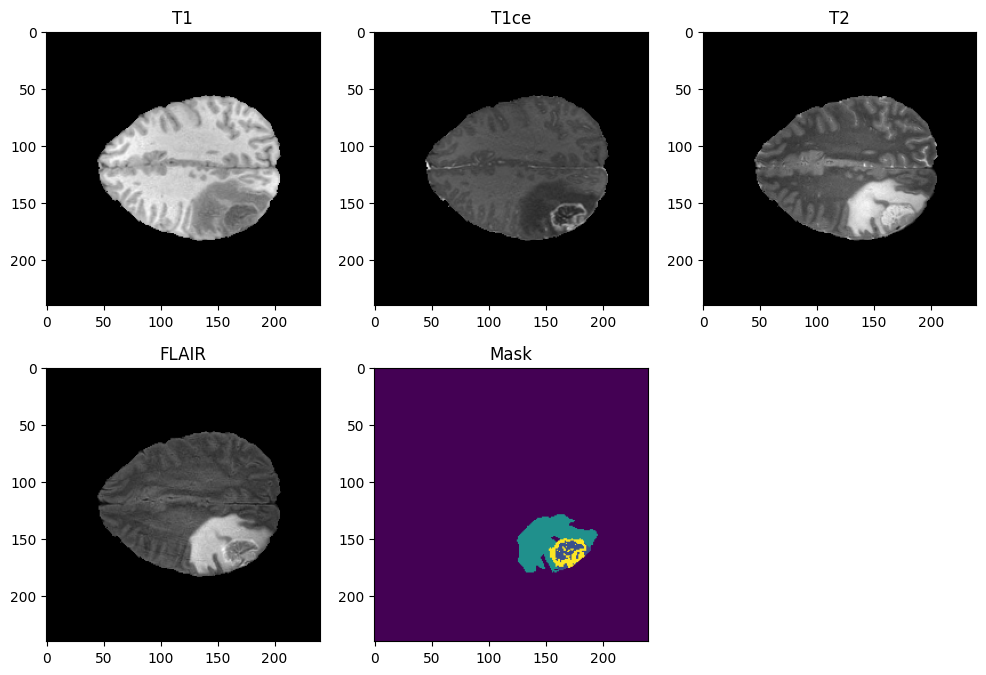

In [ ]:
slice = 95

print("Slice Number: " + str(slice))

plt.figure(figsize=(12, 8))

# T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,slice], cmap='gray')
plt.title('T1')

# T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1ce')

# T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,slice], cmap='gray')
plt.title('T2')

# Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,slice], cmap='gray')
plt.title('FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_image_seg[:,:,slice])
plt.title('Mask')
plt.show()

Les quatre modalités d’imagerie apportent des visions complémentaires d’une même image cérébrale, chacune mettant en avant des caractéristiques distinctes.

Présentation des différentes modalités :
* T1 (Native) : Permet d’observer la structure et la composition des tissus cérébraux, utile pour repérer des anomalies comme les tumeurs et les kystes.
* T1 post-contraste (T1ce ou T1Gd) : Basé sur l’imagerie T1, mais avec l’ajout d’un agent de contraste (Gadolinium) qui améliore la détection des anomalies.
* T2 pondéré (T2) : Met en évidence la présence de fluides dans les tissus cérébraux.
* T2-FLAIR (Fluid Attenuated Inversion Recovery) : Supprime les signaux des fluides, ce qui facilite la détection des lésions moins visibles sur les images T1 ou T2, notamment celles affectant la substance blanche du cerveau.

Ces quatre modalités, combinées, offrent aux spécialistes une vision détaillée pour une analyse et un diagnostic précis des tumeurs. Toutefois, dans le cadre de notre approche en intelligence artificielle, nous cherchons à optimiser l’efficacité du modèle en réduisant la charge de calcul et la mémoire utilisée. Pour cela, nous avons sélectionné uniquement deux modalités afin d’accélérer la segmentation tout en conservant la pertinence des données.


Nous avons choisi d’exclure T1, car sa version améliorée T1ce offre une meilleure clarté. En revanche, nous avons retenu T1ce, T2 et T2-FLAIR, car ces modalités fournissent des informations complémentaires essentielles. T1ce améliore la visibilité des anomalies grâce au contraste, T2 met en avant la teneur en fluide des tissus, et T2-FLAIR permet de mieux distinguer les lésions en supprimant les signaux des fluides, rendant ainsi l’analyse plus précise.

### Format des images  

Vous avez peut-être remarqué que ces images sont enregistrées au format **.nii**. Il s’agit de fichiers **NIfTI** (Neuroimaging Informatics Technology Initiative), couramment utilisés en neuroimagerie. Ce format permet de représenter numériquement des objets en trois dimensions, comme le cerveau dans notre cas. Il est particulièrement apprécié pour sa capacité à gérer efficacement des données complexes et multidimensionnelles, tout en intégrant des métadonnées essentielles sur l’orientation spatiale et l’échelle.

Pour mieux comprendre la structure des données, examinons la forme d’un scan de modalité et d’un masque de segmentation. Il est important de noter que, dans ce jeu de données, toutes les modalités et leurs masques de segmentation correspondants ont les mêmes dimensions.:


In [ ]:
# Modality shape
print("Modality: ", test_image_t1.shape)

# Segmentation shape
print("Segmentation: ", test_image_seg.shape)

Modality:  (240, 240, 155)
Segmentation:  (240, 240, 155)


##Dimensions et plans anatomiques
Les modalités et les segmentations sont représentées en trois dimensions. Chacune de ces dimensions est constituée d’une série d’images bidimensionnelles, appelées coupes, qui possèdent toutes le même nombre de pixels et sont empilées pour former cette représentation 3D. Par exemple, dans notre illustration précédente, nous avons affiché la 95ᵉ coupe d’une certaine dimension.

Ces trois dimensions correspondent aux trois plans spatiaux de l’image : largeur, hauteur et profondeur. En imagerie médicale, elles sont mieux connues sous les noms de plans axial, coronal et sagittal, qui reflètent les principales orientations du corps humain et, par extension, du cerveau.

Présentation des trois plans :
1. Plan axial (transversal) : Sépare le corps en parties supérieure et inférieure, perpendiculairement à son axe longitudinal. En imagerie cérébrale, une coupe axiale correspond à une section horizontale du cerveau.
2. Plan coronal (frontal) : Divise le corps en parties antérieure (avant) et postérieure (arrière). Une coupe coronale dans le cerveau est une section verticale d’un côté à l’autre de la tête, séparant l’avant et l’arrière du cerveau.
3. Plan sagittal (latéral) : Sépare le corps en parties gauche et droite. En imagerie cérébrale, une coupe sagittale est une section verticale allant de l’avant vers l’arrière du cerveau, divisant les hémisphères.

La compréhension de ces plans est essentielle pour interpréter correctement les images médicales et les exploiter efficacement dans les tâches de segmentation. Chaque plan offre une perspective unique, facilitant ainsi la localisation des structures anatomiques et l’identification des anomalies.









Slice number: 95


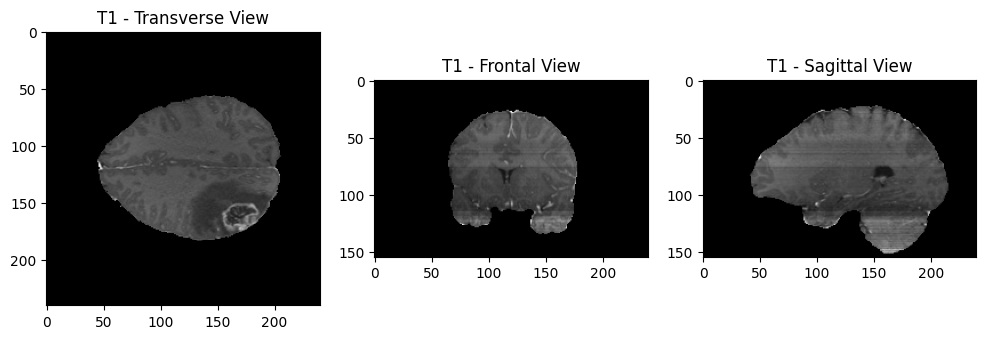

In [ ]:
slice = 95

print("Slice number: " + str(slice))

plt.figure(figsize=(12, 8))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
# T1 - Transverse View
plt.subplot(1, 3, 1)
plt.imshow(test_image_t1ce[:,:,slice], cmap='gray')
plt.title('T1 - Transverse View')

# T1 - Frontal View
plt.subplot(1, 3, 2)
plt.imshow(rotate(test_image_t1ce[:,slice,:], 90, resize=True), cmap='gray')
plt.title('T1 - Frontal View')

# T1 - Sagittal View
plt.subplot(1, 3, 3)
plt.imshow(rotate(test_image_t1ce[slice,:,:], 90, resize=True), cmap='gray')
plt.title('T1 - Sagittal View')
plt.show()

Maintenant que nous avons compris les trois dimensions de l’image, intéressons-nous au choix d’une coupe spécifique, ici la **95ᵉ**. En parcourant l’ensemble des coupes, nous pouvons identifier celle qui représente le mieux la **région d’intérêt**, notamment la zone tumorale.  

Pour illustrer cela, nous allons afficher l’ensemble des coupes selon une dimension donnée:

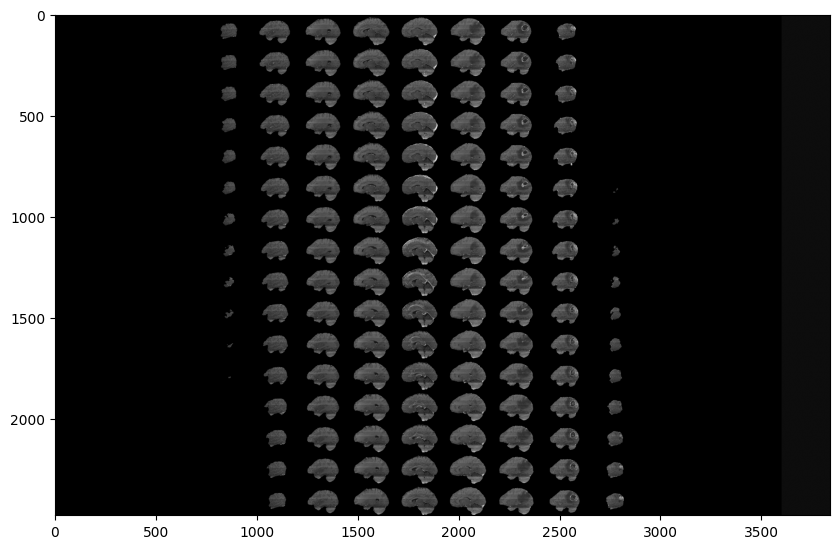

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)

# montage allows us to concatenate multiple images of the same size horizontally and vertically
plt.imshow(rotate(montage(test_image_t1ce[:,:,:]), 90, resize=True), cmap ='gray');

Comme vous pouvez le constater, deux zones noires apparaissent de part et d’autre de notre montage. Elles correspondent aux **premières et dernières coupes** du plan. Cela montre qu’une grande partie des coupes contient peu d’informations, ce qui est attendu puisque ces images représentent progressivement le cerveau d’une extrémité à l’autre.  

Cette observation est valable pour **toutes les modalités, tous les plans** et même pour les images segmentées par des experts. Ces derniers n’ont pas pu annoter les coupes dépourvues de détails significatifs, car elles capturent principalement des zones situées en dehors du cerveau ou des régions périphériques sans structures anatomiques pertinentes.  

Pour mieux illustrer cela, visualisons une série de coupes :

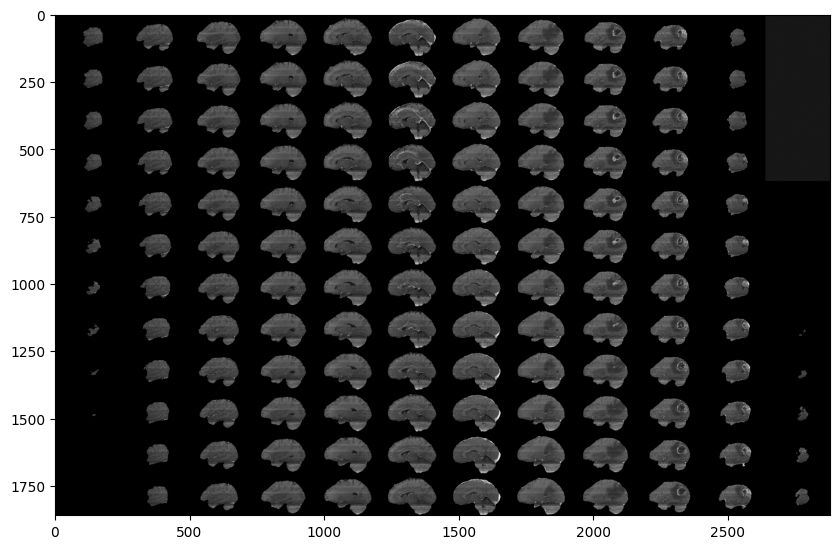

In [ ]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

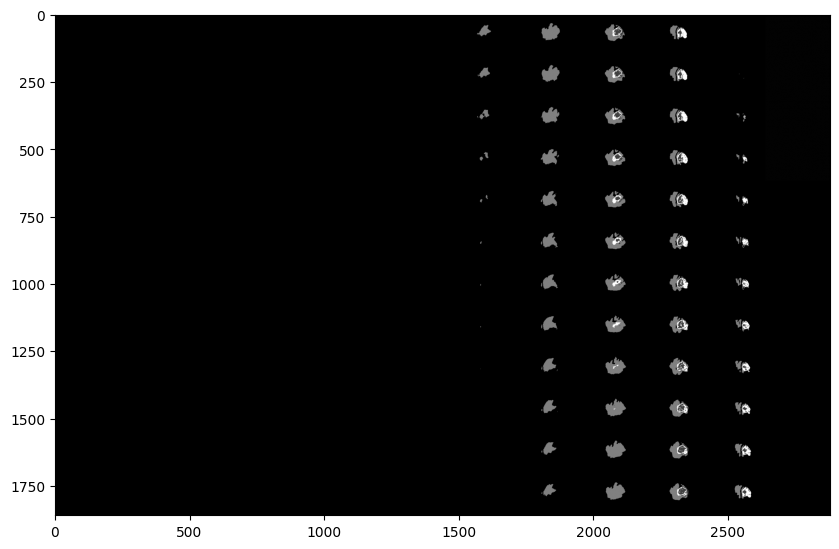

In [ ]:
# Skip 50:-50 slices since there is not much to see
plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1)
plt.imshow(rotate(montage(test_image_seg[50:-50,:,:]), 90, resize=True), cmap ='gray');

En nous concentrant sur une plage de coupes contenant des informations pertinentes, nous pouvons mieux appréhender les structures anatomiques et les zones susceptibles de présenter des anomalies, comme les tumeurs. Cette approche permet d’identifier les coupes les plus importantes pour l’analyse et la segmentation.  

Cette observation s’applique également à toutes les autres **modalités et plans**. Les images segmentées par les experts suivent le même schéma, en mettant l’accent sur les coupes riches en informations. Les coupes ne révélant qu’une faible portion de l’anatomie cérébrale sont souvent laissées non segmentées, car elles apportent peu ou pas de valeur pour le diagnostic ou l’analyse.

Concentrons-nous maintenant sur les segmentations fournies par les experts. Ces segmentations apportent des informations essentielles sur la tumeur :  

1. **Localisation** : Détermine l’emplacement exact de la tumeur dans le cerveau.  
2. **Taille et forme** : Permet de mesurer ses dimensions et sa morphologie.  
3. **Type** : Aide à distinguer les différents types de tumeurs.  
4. **Hétérogénéité** : Met en évidence les différentes composantes de la tumeur (tissu solide, zones nécrotiques, etc.).  
5. **Interaction avec les tissus environnants** : Montre comment la tumeur affecte les structures cérébrales adjacentes.  
6. **Comparaison inter-modalités** : Offre une vue globale en analysant les différences entre les modalités d’imagerie.

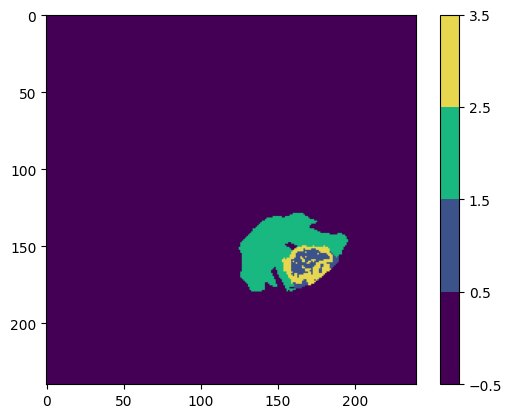

In [ ]:
# Plotting the segmantation
cmap = matplotlib.colors.ListedColormap(['#440054', '#3b528b', '#18b880', '#e6d74f'])
norm = matplotlib.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# plotting the 95th slice
plt.imshow(test_image_seg[:,:,95], cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

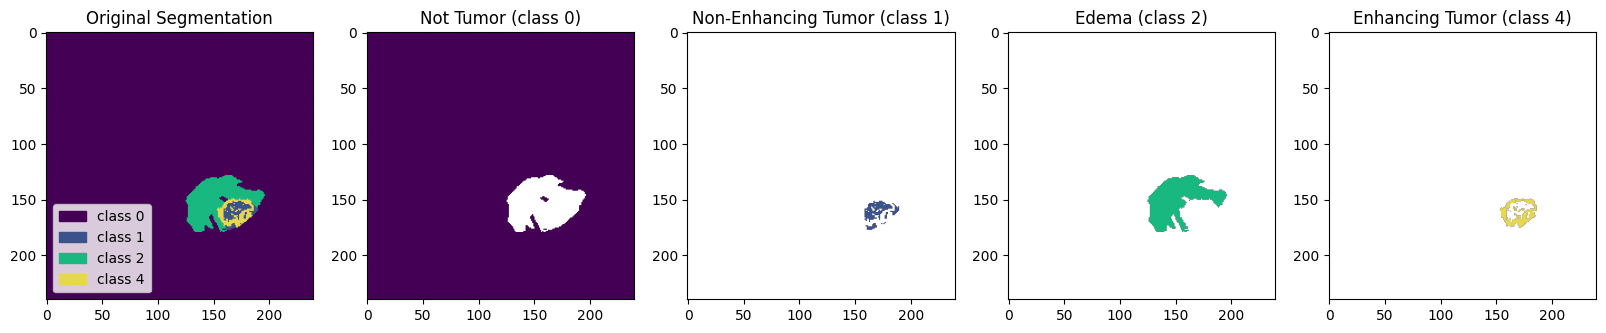

In [ ]:
# Isolation of class 0
seg_0 = test_image_seg.copy()
seg_0[seg_0 != 0] = np.nan

# Isolation of class 1
seg_1 = test_image_seg.copy()
seg_1[seg_1 != 1] = np.nan

# Isolation of class 2
seg_2 = test_image_seg.copy()
seg_2[seg_2 != 2] = np.nan

# Isolation of class 4
seg_4 = test_image_seg.copy()
seg_4[seg_4 != 4] = np.nan

# Define legend
class_names = ['class 0', 'class 1', 'class 2', 'class 4']
legend = [plt.Rectangle((0, 0), 1, 1, color=cmap(i), label=class_names[i]) for i in range(len(class_names))]

fig, ax = plt.subplots(1, 5, figsize=(20, 20))

ax[0].imshow(test_image_seg[:,:, slice], cmap=cmap, norm=norm)
ax[0].set_title('Original Segmentation')
ax[0].legend(handles=legend, loc='lower left')

ax[1].imshow(seg_0[:,:, slice], cmap=cmap, norm=norm)
ax[1].set_title('Not Tumor (class 0)')

ax[2].imshow(seg_1[:,:, slice], cmap=cmap, norm=norm)
ax[2].set_title('Non-Enhancing Tumor (class 1)')

ax[3].imshow(seg_2[:,:, slice], cmap=cmap, norm=norm)
ax[3].set_title('Edema (class 2)')

ax[4].imshow(seg_4[:,:, slice], cmap=cmap, norm=norm)
ax[4].set_title('Enhancing Tumor (class 4)')

plt.show()

Ces données sont indispensables pour un diagnostic fiable, une élaboration optimale du traitement et un suivi rigoureux. Les segmentations offrent une visualisation détaillée de la tumeur, ce qui aide à mieux appréhender ses particularités et ses interactions avec les structures voisines.

Pour résumer notre analyse des données :

* **Modalités** : Chaque patient dispose de 4 modalités d'imagerie différentes (T1, T1CE, T2 et FLAIR), accompagnées d'une segmentation délimitant les zones tumorales.
* **Modalités retenues** : Nous avons choisi de nous concentrer sur T1CE et FLAIR, car elles apportent des informations complémentaires sur l'anatomie cérébrale et le contraste des tissus.
* **Images en 3D** : Les images sont en trois dimensions et peuvent être examinées sous trois plans différents, chacun composé de tranches 2D.
* **Tranches significatives** : Un grand nombre de tranches ne contiennent que peu d'informations utiles. Nous nous concentrerons sur les tranches dans l'intervalle (50:-50), bien que ce choix puisse être ajusté, il impactera le temps d'entraînement.
* **Classes de segmentation** : Les images de segmentation comportent de 1 à 4 classes. La classe 4 sera réaffectée à la classe 3, car cette dernière est absente.
* **Classe de fond** : La classe 0 (le fond) est sur-représentée. Plutôt que de rogner les images, ce qui pourrait supprimer des informations cruciales, nous choisirons de les conserver telles quelles.

Avec cette compréhension des données, nous pouvons désormais nous préparer à l'entraînement du modèle.

# 5. Split dataset

Pour entraîner et évaluer efficacement notre modèle, nous devons diviser notre dataset en trois ensembles :  
- **Ensemble d'entraînement (80%)** : utilisé pour entraîner le modèle.  
- **Ensemble de validation (10%)** : permet d'ajuster les hyperparamètres et de prévenir le sur-apprentissage (*overfitting*).  
- **Ensemble de test (10%)** : utilisé pour évaluer les performances finales du modèle.  

Nous pouvons effectuer un fractionnement aléatoire des données ou un fractionnement stratifié, ce dernier permettant de conserver la même distribution des classes dans chaque ensemble, ce qui est particulièrement utile pour les datasets déséquilibrés. Un bon fractionnement garantit un modèle robuste et performant sur des données non vues.


In [ ]:
from sklearn.model_selection import train_test_split
# Liste tous les patients (dossiers) dans le dataset
patients = [f for f in os.listdir(TRAIN_DATASET_PATH) if os.path.isdir(os.path.join(TRAIN_DATASET_PATH, f))]

# Mélange aléatoire des patients
np.random.shuffle(patients)

# Fractionnement des données (80% train, 10% val, 10% test)
train_patients, temp_patients = train_test_split(patients, test_size=0.2, random_state=42)
val_patients, test_patients = train_test_split(temp_patients, test_size=0.5, random_state=42)

# Afficher les tailles des ensembles
print(f"Nombre de patients dans l'ensemble d'entraînement : {len(train_patients)}")
print(f"Nombre de patients dans l'ensemble de validation : {len(val_patients)}")
print(f"Nombre de patients dans l'ensemble de test : {len(test_patients)}")

Nombre de patients dans l'ensemble d'entraînement : 295
Nombre de patients dans l'ensemble de validation : 37
Nombre de patients dans l'ensemble de test : 37


In [ ]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

# 6. Générateur de données (DataGenerator)

Pour entraîner un réseau de neurones à la segmentation d’images, nous avons besoin à la fois des images brutes (X) et des segmentations de référence (y). Cela permet au réseau d’apprendre les motifs tumoraux et de faire des prédictions précises à partir des scans des patients. Cependant, charger directement toutes les images 3D peut surcharger la mémoire du système et provoquer des erreurs de dimensions. C’est pourquoi nous utilisons un générateur de données pour le prétraitement des images, qui suit plusieurs étapes :

1. **Récupération des chemins** : Obtenir les chemins des modalités FLAIR,T1CE et T2 (fournissant des informations complémentaires sur l’anatomie et le contraste tissulaire) ainsi que la segmentation de référence.
2. **Chargement des données** : Charger les tranches sélectionnées (60-135) de ces modalités et la segmentation correspondante.
3. **Création des tableaux** : Construire les tableaux X avec les tranches de FLAIR,T1CE et T2 et les tableaux y avec les tranches de segmentation.
4. **Réattribution des classes** : Assigner la valeur 3 à toutes les occurrences de 4 dans le masque afin de corriger le problème de classe manquante.


In [ ]:
# Define seg-areas
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3
}

# Select Slices and Image Size
VOLUME_SLICES = 100
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE, IMG_SIZE), batch_size=1, n_channels=3, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels  # Maintenant 3 canaux : FLAIR, T1CE, T2
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, self.n_channels))  # 3 canaux
        y = np.zeros((self.batch_size * VOLUME_SLICES, 240, 240))  # Masques non redimensionnés
        Y = np.zeros((self.batch_size * VOLUME_SLICES, *self.dim, 4))  # Masques one-hot encodés

        # Generate data
        for c, patient_id in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, patient_id)

            # Charger les modalités d'images
            flair = nib.load(os.path.join(case_path, f'{patient_id}_flair.nii')).get_fdata()
            t1ce = nib.load(os.path.join(case_path, f'{patient_id}_t1ce.nii')).get_fdata()
            t2 = nib.load(os.path.join(case_path, f'{patient_id}_t2.nii')).get_fdata()

            # Charger le masque de segmentation
            seg = nib.load(os.path.join(case_path, f'{patient_id}_seg.nii')).get_fdata()

            for j in range(VOLUME_SLICES):
                # Redimensionner les images
                X[j + VOLUME_SLICES * c, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * c, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], self.dim)
                X[j + VOLUME_SLICES * c, :, :, 2] = cv2.resize(t2[:, :, j + VOLUME_START_AT], self.dim)

                # Redimensionner les masques sans interpolation
                y[j + VOLUME_SLICES * c] = seg[:, :, j + VOLUME_START_AT]

        # Remplacer les valeurs 4 par 3 dans les masques
        y[y == 4] = 3

        # Encodage one-hot des masques
        mask = tf.one_hot(y.astype(np.int32), depth=4)

        # Redimensionner les masques one-hot encodés
        Y = tf.image.resize(mask, self.dim, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        # Normaliser les images
        X = (X - np.min(X)) / (np.max(X) - np.min(X) + 1e-7)

        return X, Y

In [ ]:
training_generator = DataGenerator(train_patients)
valid_generator = DataGenerator(val_patients)
test_generator = DataGenerator(test_patients)

In [ ]:
X_batch, Y_batch = training_generator[0]
print("X_batch shape:", X_batch.shape)
print("Y_batch shape:", Y_batch.shape)
print("X_batch min/max:", np.min(X_batch), np.max(X_batch))
print("Y_batch unique values:", np.unique(Y_batch))

X_batch shape: (100, 128, 128, 3)
Y_batch shape: (100, 128, 128, 4)
X_batch min/max: 0.0 0.9999999999405622
Y_batch unique values: [0. 1.]


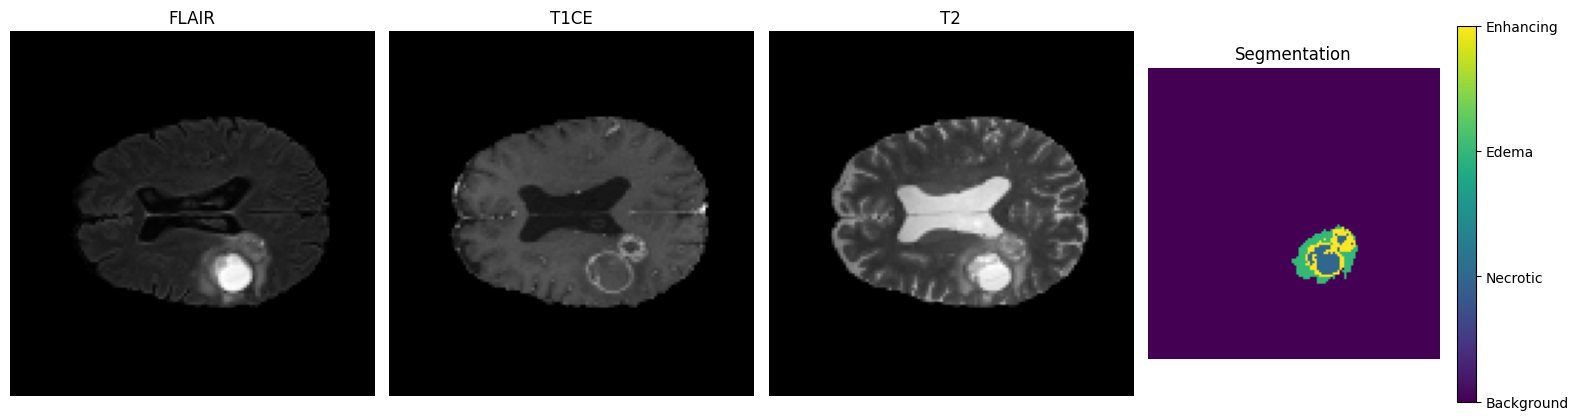

In [ ]:
import matplotlib.pyplot as plt

# Define a function to display one slice and its segmentation
def display_slice_and_segmentation(flair, t1ce, t2, segmentation):
    """
    Affiche une tranche d'image FLAIR, T1CE, T2 et sa segmentation correspondante.
    """
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))  # Ajout d'un sous-graphique pour T2

    # Afficher l'image FLAIR
    axes[0].imshow(flair, cmap='gray')
    axes[0].set_title('FLAIR')
    axes[0].axis('off')

    # Afficher l'image T1CE
    axes[1].imshow(t1ce, cmap='gray')
    axes[1].set_title('T1CE')
    axes[1].axis('off')

    # Afficher l'image T2
    axes[2].imshow(t2, cmap='gray')
    axes[2].set_title('T2')
    axes[2].axis('off')

    # Afficher la segmentation
    segmentation_colored = axes[3].imshow(segmentation, cmap='viridis', vmin=0, vmax=3)
    axes[3].set_title('Segmentation')
    axes[3].axis('off')

    # Ajouter une barre de couleur pour la segmentation
    cbar = fig.colorbar(segmentation_colored, ax=axes[3], orientation='vertical', shrink=0.8)
    cbar.set_ticks([0, 1, 2, 3])
    cbar.set_ticklabels(['Background', 'Necrotic', 'Edema', 'Enhancing'])

    plt.tight_layout()
    plt.show()


# Récupérer un batch depuis le générateur d'entraînement
X_batch, Y_batch = training_generator[0]  # Prendre le premier batch (index 0)

# Extraire les modalités FLAIR, T1CE, T2 et la segmentation à partir du batch
flair_batch = X_batch[:, :, :, 0]  # Modalité FLAIR
t1ce_batch = X_batch[:, :, :, 1]   # Modalité T1CE
t2_batch = X_batch[:, :, :, 2]     # Modalité T2
segmentation_batch = np.argmax(Y_batch, axis=-1)  # Convertir le masque one-hot en classes discrètes

# Sélectionner une tranche spécifique (par exemple, la 60e tranche)
slice_index = 60  # Index de la tranche à afficher
slice_flair = flair_batch[slice_index]
slice_t1ce = t1ce_batch[slice_index]
slice_t2 = t2_batch[slice_index]
slice_segmentation = segmentation_batch[slice_index]

# Afficher la tranche sélectionnée et sa segmentation
display_slice_and_segmentation(slice_flair, slice_t1ce, slice_t2, slice_segmentation)

# 7. Fonction de perte et métriques d'évaluation

### **Fonction de Perte**  

Lors de l'entraînement d'un réseau de neurones convolutionnel (CNN), le choix d'une fonction de perte appropriée est essentiel pour évaluer avec précision les performances du modèle. Cette fonction compare les pixels prédits à la vérité terrain pour chaque patient, permettant ainsi au modèle d'ajuster ses poids afin de minimiser la perte et d'améliorer la précision des prédictions.  

Pour les problèmes de classification multi-classes, une fonction de perte couramment utilisée est l'**entropie croisée catégorielle** (*categorical cross-entropy*). Elle mesure la différence entre la distribution de probabilité prédite pour chaque pixel et les valeurs de vérité terrain encodées en *one-hot*.  

De plus, dans les modèles de segmentation, on utilise parfois la **fonction de perte de Dice** (*Dice loss*), qui met l'accent sur le chevauchement entre les segments prédits et réels. Cela permet d'améliorer encore la précision de la segmentation.  

L'utilisation de ces fonctions de perte garantit un apprentissage efficace du modèle et une segmentation précise des tumeurs cérébrales.

In [ ]:
import tensorflow as tf
from keras import backend as K

def dice_coef(y_true, y_pred):
    smooth=1.0
    class_num = 4
    total_loss = 0
    for i in range(class_num):
        y_true_f = tf.reshape(y_true[:, :, :, i], (-1,))
        y_pred_f = tf.reshape(y_pred[:, :, :, i], (-1,))

        intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Replacing K.sum() with tf.reduce_sum()
        loss = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

        total_loss += loss

    return total_loss / class_num

### Fonctions du Coefficient de Dice par Classe

Ces fonctions calculent le coefficient de Dice pour des classes spécifiques de tumeurs dans les tâches de segmentation, permettant d’évaluer les performances du modèle dans la prédiction des différentes régions tumorales :

- **dice_coef_necrotic** : Calcule le coefficient de Dice pour la région tumorale nécrotique (tissu mort). Il mesure l’intersection sur la somme des carrés des valeurs réelles et prédites pour la classe nécrotique.

- **dice_coef_edema** : Calcule le coefficient de Dice pour la région tumorale œdémateuse (gonflement). Il mesure l’intersection sur la somme des carrés des valeurs réelles et prédites pour la classe de l’œdème.

- **dice_coef_enhancing** : Calcule le coefficient de Dice pour la région tumorale rehaussée. Il mesure l’intersection sur la somme des carrés des valeurs réelles et prédites pour la classe de la tumeur rehaussée.

In [ ]:
# Define per-class evaluation of Dice coefficient
def dice_coef_necrotic(y_true, y_pred):
    epsilon = 1e-6
    intersection = tf.reduce_sum(tf.abs(y_true[:, :, :, 1] * y_pred[:, :, :, 1]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:, :, :, 1])) + tf.reduce_sum(tf.square(y_pred[:, :, :, 1])) + epsilon)

def dice_coef_edema(y_true, y_pred):
    epsilon = 1e-6
    intersection = tf.reduce_sum(tf.abs(y_true[:, :, :, 2] * y_pred[:, :, :, 2]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:, :, :, 2])) + tf.reduce_sum(tf.square(y_pred[:, :, :, 2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred):
    epsilon = 1e-6
    intersection = tf.reduce_sum(tf.abs(y_true[:, :, :, 3] * y_pred[:, :, :, 3]))
    return (2. * intersection) / (tf.reduce_sum(tf.square(y_true[:, :, :, 3])) + tf.reduce_sum(tf.square(y_pred[:, :, :, 3])) + epsilon)


### Métriques d'Évaluation

Pour surveiller efficacement les performances du modèle, nous utilisons plusieurs métriques d’évaluation :

- **Exactitude (Accuracy)** : Mesure la proportion globale de pixels correctement classifiés. Toutefois, cette métrique peut être trompeuse sur des jeux de données déséquilibrés comme BraTS2020, où la classe de fond est surreprésentée.
- **Intersection over Union (IoU)** : Évalue le chevauchement entre les segmentations prédites et celles de référence.
- **Coefficient de Dice** : Mesure la similarité entre les segmentations prédites et celles de référence.
- **Sensibilité (Recall ou Taux de Vrais Positifs)** : Mesure la proportion de pixels positifs dans la vérité terrain correctement prédits comme positifs.
- **Précision (Valeur Prédictive Positive)** : Mesure la proportion de pixels prédits comme positifs qui sont réellement positifs.
- **Spécificité (Taux de Vrais Négatifs)** : Mesure la proportion de pixels négatifs dans la vérité terrain correctement prédits comme négatifs.

L'utilisation de ces métriques permet d’évaluer de manière plus complète les performances du modèle, en compensant les limites de l'exactitude seule sur des datasets déséquilibrés.


In [ ]:

# Computing Precision
def precision(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    predicted_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Computing Sensitivity (Recall)
def sensitivity(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true * y_pred, 0, 1)))
    possible_positives = tf.reduce_sum(tf.round(tf.clip_by_value(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.round(tf.clip_by_value((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = tf.reduce_sum(tf.round(tf.clip_by_value(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# 8. Définition du Modèle de Segmentation

### TransUNet

Dans ce projet, nous utiliserons également l’architecture **TransUNet**, un modèle hybride combinant les **réseaux de neurones convolutifs (CNN)** et les **Transformers**, conçu pour améliorer la segmentation d’images médicales. Proposé par **Chen et al.** dans l’article [TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation](https://arxiv.org/abs/2102.04306), ce modèle exploite la capacité des Transformers à capturer des **dépendances globales** dans les images, tout en conservant les avantages des CNN pour l’extraction locale de caractéristiques.

**TransUNet** repose sur une structure d’**encodeur-décodeur**, où l’encodeur est basé sur un **Vision Transformer (ViT)** préentraîné, souvent sur de grandes bases d’images comme ImageNet, et le décodeur suit une structure similaire à celle de **U-Net**. Ce couplage permet au modèle de tirer parti à la fois des **relations globales** (grâce aux Transformers) et de la **localisation précise** (grâce aux CNN et aux blocs de décodage).

Ce modèle est particulièrement adapté à la **segmentation de structures complexes** dans les images médicales, comme les tumeurs cérébrales en IRM, car il permet de contextualiser chaque région en tenant compte de l’image dans son ensemble.

- **Avantages de TransUNet** :
  - Excellente capacité à **modéliser des relations globales** à travers toute l’image, même à longue distance.
  - Performance élevée sur des tâches de segmentation complexes, notamment dans les cas où les objets cibles présentent une **variabilité de forme et de taille** importante.
  - Utilisation de **Transformers préentraînés**, favorisant une généralisation plus rapide et plus stable.

- **Limites de TransUNet** :
  - **Très gourmand en ressources**, notamment en mémoire GPU et en temps de calcul, en particulier pour des images 3D ou de grande taille.
  - Requiert un **prétraitement** spécifique (comme le partitionnement en patchs pour les Transformers), ce qui ajoute une étape supplémentaire au pipeline.
  - Peut être **moins performant sur de petits datasets** sans pré-entraînement adapté, en raison de sa complexité.

Pour ce projet, nous envisagerons l’usage d’une **implémentation 2D de TransUNet**, en traitant les IRM 3D sous forme de tranches 2D, afin de limiter la charge computationnelle. Cette approche permet de bénéficier des **capacités de contextualisation des Transformers** tout en maintenant une compatibilité avec les pipelines classiques de segmentation en 2D.

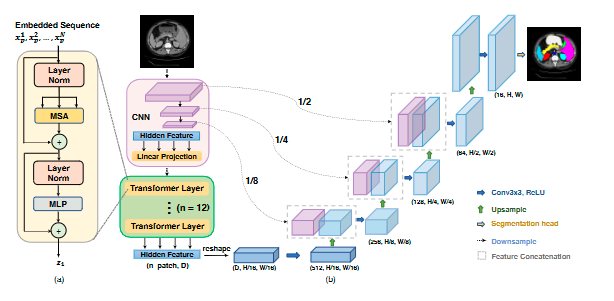

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape,
                                     LayerNormalization, MultiHeadAttention, Add, Concatenate, UpSampling2D)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

# Configuration du modèle
IMG_SIZE = 128  # Taille de l'image d'entrée
PATCH_SIZE = 16  # Taille des patchs
EMBED_DIM = 512  # Dimension des embeddings
NUM_HEADS = 8  # Nombre de têtes d'attention
NUM_LAYERS = 4  # Nombre de couches Transformer
NUM_CLASSES = 4  # Nombre de classes pour la segmentation

# Couche d'extraction de patchs

class PatchExtraction(Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtraction, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='SAME'
        )
        return patches

    def get_config(self):
        config = super(PatchExtraction, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config

# Positional Encoding
def positional_encoding(length, depth):
    depth = depth / 2
    positions = tf.range(length, dtype=tf.float32)[:, tf.newaxis]
    depths = tf.range(depth, dtype=tf.float32)[tf.newaxis, :] / depth
    angle_rates = 1 / (10000 ** depths)
    angle_rads = positions * angle_rates
    pos_encoding = tf.concat([tf.sin(angle_rads), tf.cos(angle_rads)], axis=-1)
    return tf.cast(pos_encoding, dtype=tf.float32)

# Transformer Encoder Block
def transformer_block(inputs, embed_dim, num_heads):
    x = LayerNormalization()(inputs)
    x = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim // num_heads)(x, x)
    x = Add()([x, inputs])
    x = LayerNormalization()(x)
    x = Dense(embed_dim // 2, activation='relu')(x)
    x = Dense(embed_dim)(x)
    return Add()([x, inputs])

# Encodeur CNN (ResNet-like)
def cnn_encoder(inputs):
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(inputs)
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2D(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    return x

# Construction de TransUNet complet
def build_transunet(img_size, patch_size, embed_dim, num_heads, num_layers, num_classes):
    inputs = Input(shape=(img_size, img_size, 3))

    # === 1. Encodeur CNN ===
    cnn_features = cnn_encoder(inputs)  # Caractéristiques locales

    # === 2. Encodeur Transformer ===
    # Extraction des patchs
    patches = PatchExtraction(patch_size)(inputs)
    patches = Reshape((-1, patch_size * patch_size * 3))(patches)  # Forme des patchs
    patch_embeddings = Dense(embed_dim)(patches)  # Transformation en embeddings

    # Ajout du positional encoding
    num_patches = (img_size // patch_size) ** 2
    pos_encoding = positional_encoding(num_patches, embed_dim)
    patch_embeddings += pos_encoding  # Ajout du positional encoding

    # Passage à travers les couches Transformer
    x = patch_embeddings
    for _ in range(num_layers):
        x = transformer_block(x, embed_dim, num_heads)

    # Reshape pour reconstruire une carte de caractéristiques 2D
    feature_map_size = img_size // patch_size
    x = Reshape((feature_map_size, feature_map_size, embed_dim))(x)

    # === 3. Fusion des caractéristiques ===
    # Upsample 'x' before concatenation to match the spatial dimensions of 'cnn_features'
    x = UpSampling2D(size=(2, 2), interpolation='bilinear')(x)  # Upsample by a factor of 2

    fused_features = Concatenate()([cnn_features, x])  # Fusion des caractéristiques CNN et Transformer

    # === 4. Décodage U-Net ===
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(fused_features)
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(x)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(x)  # Sortie multi-classe

    return Model(inputs, outputs)

# Création du modèle complet
model = build_transunet(IMG_SIZE, PATCH_SIZE, EMBED_DIM, NUM_HEADS, NUM_LAYERS, NUM_CLASSES)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_extraction    │ (None, 8, 8, 768) │          0 │ input_layer[0][0] │
│ (PatchExtraction)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 64, 768)   │          0 │ patch_extraction… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 512)   │    393,728 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 512)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 64, 512)   │      1,024 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 512)   │  1,050,624 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 512)   │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 512)   │      1,024 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64, 256)   │    131,328 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64, 512)   │    131,584 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 512)   │          0 │ dense_2[0][0],    │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 512)   │      1,024 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 64, 512)   │  1,050,624 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 64, 512)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 64, 512)   │      1,024 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64, 256)   │    131,328 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64, 512)   │    131,584 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 64, 512)   │          0 │ dense_4[0][0],    │
│                     │                   │            │ add_2[0][0]     

 Total params: 9,935,684 (37.90 MB)

 Trainable params: 9,935,684 (37.90 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing])

In [ ]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                      patience=2, min_lr=0.000001, verbose=1),
    keras.callbacks.ModelCheckpoint(filepath='/content/transunetDir/model_.{epoch:02d}-{val_loss:.6f}.weights.h5',
                                    verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger('/content/transunetDir/training.log', separator=',', append=False)
]


# 9. Entraînement et Sauvegarde du Modèle

Nous sommes maintenant prêts à entraîner notre réseau de neurones profond en utilisant la méthode `.fit()` de **Keras**. Nous intégrerons trois callbacks dans cette méthode, qui seront exécutés tout au long du processus d'entraînement, lequel durera **35 époques**.
```

In [ ]:
! mkdir transunetDir

In [ ]:
K.clear_session()

history =  model.fit(training_generator,
                    epochs=35,
                    steps_per_epoch=len(train_patients),
                    callbacks= callbacks,
                    validation_data = valid_generator
                    )

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 703ms/step - accuracy: 0.9598 - dice_coef: 0.2586 - dice_coef_edema: 0.0908 - dice_coef_enhancing: 0.0425 - dice_coef_necrotic: 0.0485 - loss: 0.1535 - mean_io_u: 0.4054 - precision: 0.9448 - sensitivity: 0.9382 - specificity: 0.9947
Epoch 1: val_loss improved from inf to 0.07054, saving model to /content/transunetDir/model_.01-0.070537.weights.h5
295/295 ━━━━━━━━━━━━━━━━━━━━ 301s 856ms/step - accuracy: 0.9598 - dice_coef: 0.2587 - dice_coef_edema: 0.0909 - dice_coef_enhancing: 0.0425 - dice_coef_necrotic: 0.0485 - loss: 0.1533 - mean_io_u: 0.4055 - precision: 0.9449 - sensitivity: 0.9383 - specificity: 0.9947 - val_accuracy: 0.9837 - val_dice_coef: 0.2707 - val_dice_coef_edema: 0.0768 - val_dice_coef_enhancing: 0.0267 - val_dice_coef_necrotic: 0.0458 - val_loss: 0.0705 - val_mean_io_u: 0.7042 - val_precision: 0.9845 - val_sensitivity: 0.9830 - val_specificity: 0.9948 - learning_rate: 0.0010
Epoch 2/35
295/295 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/ste

In [ ]:
model.save("/content/transunetDir/my_transunet_model.keras")

# 10. Chargement du Modèle Entraîné

Nous allons charger notre modèle de réseau de neurones entraîné en utilisant **Keras**. La méthode `load_model` nous permet de recharger le modèle sauvegardé, y compris les métriques personnalisées et les fonctions de perte définies lors de l'entraînement. Voici comment procéder :


In [ ]:
model = keras.models.load_model('/content/transunetDir/my_transunet_model.keras',
                                   custom_objects={"accuracy" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "PatchExtraction": PatchExtraction,
                                                   "dice_coef" : dice_coef,
                                                   "precision" : precision,
                                                   "sensitivity" :sensitivity,
                                                   "specificity" :specificity,
                                                   "dice_coef_necrotic" : dice_coef_necrotic,
                                                   "dice_coef_edema" : dice_coef_edema,
                                                   "dice_coef_enhancing" : dice_coef_enhancing
                                                  }, compile=False)

Nous spécifions le chemin vers notre modèle sauvegardé et fournissons un dictionnaire d'`custom_objects` pour garantir que nos métriques et fonctions de perte personnalisées soient correctement reconnues par **Keras**. En définissant `compile=False`, nous pouvons charger l'architecture et les poids du modèle sans le compiler immédiatement, ce qui nous permet d'ajuster les paramètres de compilation si nécessaire.



# 11. Analyse des Métriques

Maintenant que l'entraînement est terminé, nous pouvons examiner le callback **CSVLogger** pour obtenir des informations sur le processus d'entraînement et les performances de notre modèle. Le **CSVLogger** enregistre des métriques telles que l'exactitude, la perte, le coefficient de Dice et la Mean IoU pour chaque époque, ce qui nous permet de suivre les progrès du modèle au fil du temps. En analysant ce journal, nous pouvons identifier des tendances, évaluer l'efficacité de notre stratégie d'entraînement et prendre des décisions éclairées pour les améliorations futures. Cette revue approfondie garantit que notre modèle fonctionne de manière optimale et est prêt pour le déploiement.


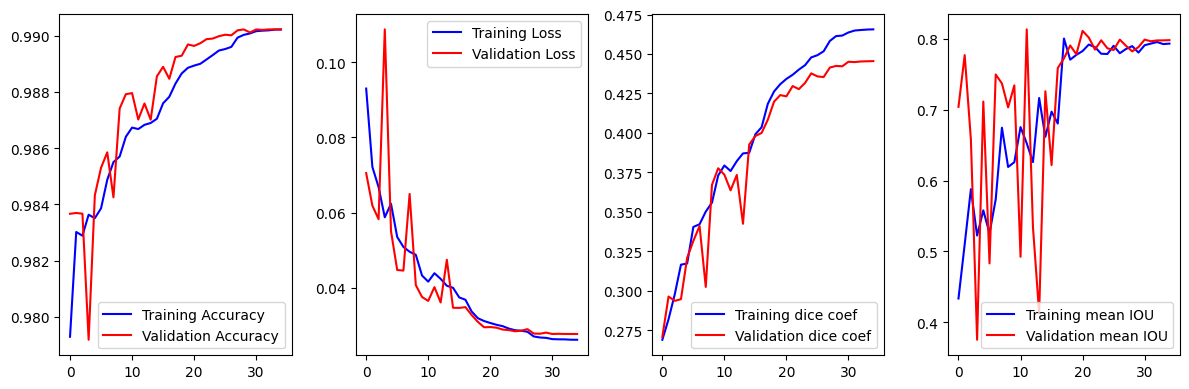

In [ ]:
history = pd.read_csv('/content/transunetDir/training.log', sep=',', engine='python')

hist=history

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

precision =hist['precision']
val_precision=hist['val_precision']

sensitivity= hist['sensitivity']
val_sensitivity= hist['val_sensitivity']

specificity= hist['specificity']
val_specificity= hist['val_specificity']

dice_coef_necrotic= hist['dice_coef_necrotic']
val_dice_coef_necrotic= hist['val_dice_coef_necrotic']

dice_coef_edema = hist['dice_coef_edema']
val_dice_coef_edema = hist['val_dice_coef_edema']

dice_coef_enhancing= hist['dice_coef_enhancing']
val_dice_coef_enhancing= hist['val_dice_coef_enhancing']

f, ax = plt.subplots(1, 4, figsize=(12, 4))

ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch, train_dice, 'b', label='Training dice coef')
ax[2].plot(epoch, val_dice, 'r', label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch, hist['mean_io_u'], 'b', label='Training mean IOU')
ax[3].plot(epoch, hist['val_mean_io_u'], 'r', label='Validation mean IOU')
ax[3].legend()

plt.tight_layout()
plt.show()


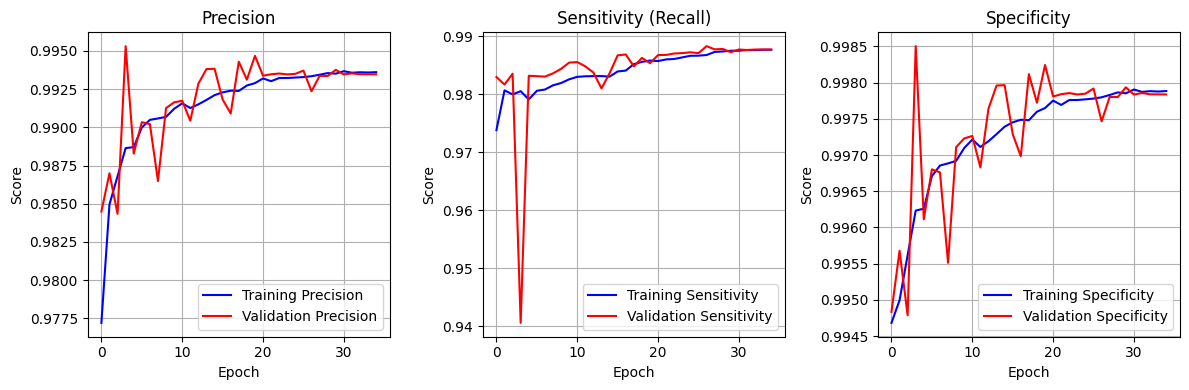

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

# 1. Precision
ax[0].plot(epoch, hist['precision'], 'b', label='Training Precision')
ax[0].plot(epoch, hist['val_precision'], 'r', label='Validation Precision')
ax[0].set_title('Precision')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Score')
ax[0].legend()
ax[0].grid(True)

# 2. Sensitivity (Recall)
ax[1].plot(epoch, hist['sensitivity'], 'b', label='Training Sensitivity')
ax[1].plot(epoch, hist['val_sensitivity'], 'r', label='Validation Sensitivity')
ax[1].set_title('Sensitivity (Recall)')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Score')
ax[1].legend()
ax[1].grid(True)

# 3. Specificity
ax[2].plot(epoch, hist['specificity'], 'b', label='Training Specificity')
ax[2].plot(epoch, hist['val_specificity'], 'r', label='Validation Specificity')
ax[2].set_title('Specificity')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Score')
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()


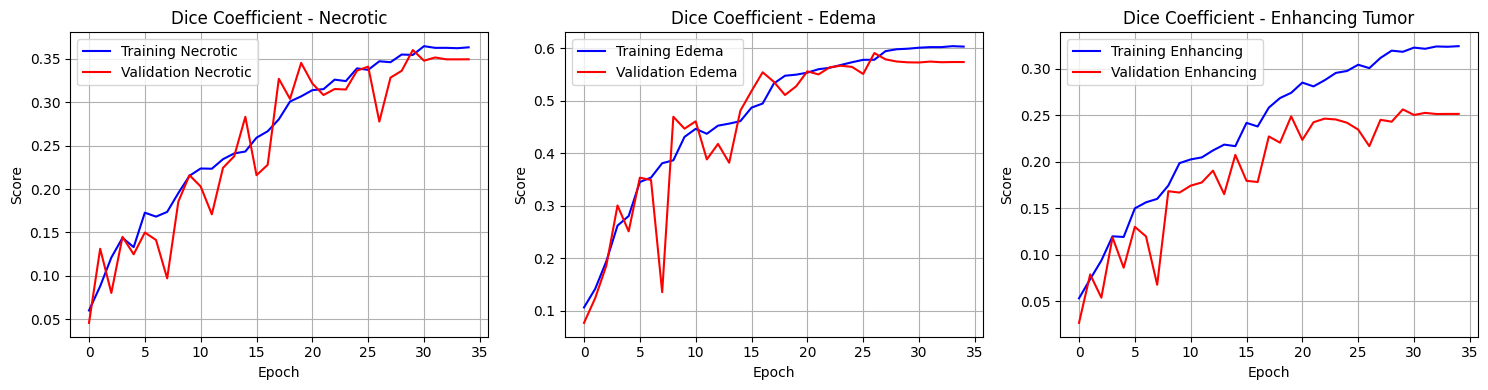

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

# Dice Coef - Necrotic
ax[0].plot(epoch, dice_coef_necrotic, 'b', label='Training Necrotic')
ax[0].plot(epoch, val_dice_coef_necrotic, 'r', label='Validation Necrotic')
ax[0].set_title('Dice Coefficient - Necrotic')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Score')
ax[0].legend()
ax[0].grid(True)

# Dice Coef - Edema
ax[1].plot(epoch, dice_coef_edema, 'b', label='Training Edema')
ax[1].plot(epoch, val_dice_coef_edema, 'r', label='Validation Edema')
ax[1].set_title('Dice Coefficient - Edema')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Score')
ax[1].legend()
ax[1].grid(True)

# Dice Coef - Enhancing Tumor
ax[2].plot(epoch, dice_coef_enhancing, 'b', label='Training Enhancing')
ax[2].plot(epoch, val_dice_coef_enhancing, 'r', label='Validation Enhancing')
ax[2].set_title('Dice Coefficient - Enhancing Tumor')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Score')
ax[2].legend()
ax[2].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Paramètres globaux
IMG_SIZE = 128
VOLUME_SLICES = 64
VOLUME_START_AT = 24

# 12. Prédire les Segmentations de Tumeurs

Une fois que notre modèle est entraîné, nous pouvons l'utiliser pour prédire les segmentations des tumeurs sur de nouvelles images. Cela nous permet d'analyser les résultats de segmentation du modèle sur des données inédites, en comparant les prédictions aux segmentations de référence (ground truth). Pour ce faire, nous utilisons la méthode `.predict()` de Keras, qui génère les prédictions sur des échantillons d'images en entrée. Ces prédictions peuvent ensuite être visualisées ou utilisées pour calculer des métriques de performance supplémentaires.
```

In [ ]:
from skimage import morphology

def postprocess_mask(mask_pred, min_size=20, hole_size=20):
    """
    Post-traitement minimal pour améliorer la segmentation :
    - Suppression des petits objets (faux positifs isolés)
    - Remplissage des petits trous dans les régions segmentées
    - Lissage morphologique par ouverture
    """
    mask_pp = np.zeros_like(mask_pred)
    classes = np.unique(mask_pred)
    for c in classes:
        if c == 0:
            continue  # Ne pas traiter le fond
        mask_c = (mask_pred == c)

        # Suppression des petits objets
        mask_c = morphology.remove_small_objects(mask_c, min_size=min_size)

        # Remplissage des petits trous
        mask_c = morphology.remove_small_holes(mask_c, area_threshold=hole_size)

        # Lissage morphologique (ouverture)
        selem = morphology.disk(2)  # élément structurant circulaire de rayon 2 pixels
        mask_c = morphology.opening(mask_c, selem)

        mask_pp[mask_c] = c
    return mask_pp


In [ ]:
def prediction_func(case_path, case):
    # Initialiser le tableau d'entrée
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 3))  # 3 modalités : FLAIR, T1CE, T2

    # Charger les modalités
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')
    flair = nib.load(vol_path).get_fdata()
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii')
    t1ce = nib.load(vol_path).get_fdata()
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t2.nii')
    t2 = nib.load(vol_path).get_fdata()

    # Redimensionner et stocker les slices
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 2] = cv2.resize(t2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normaliser les données
    X = X / np.max(X)

    # Prédiction brute du modèle
    y_pred = model.predict(X, verbose=1)
    mask_pred = np.argmax(y_pred, axis=-1)

    # Post-traitement slice par slice
    mask_post = np.zeros_like(mask_pred)
    for i in range(mask_pred.shape[0]):
        mask_post[i] = postprocess_mask(mask_pred[i], min_size=20, hole_size=20)

    # Retourne aussi X pour la visualisation/Grad-CAM
    return mask_post, X


In [ ]:
def get_grad_cam(model, img_array, layer_name="conv2d_3"):

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        inputs = tf.cast(img_array[np.newaxis, ...], tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        pred_index = tf.argmax(tf.reduce_max(predictions, axis=(1,2)), axis=-1)
        loss = predictions[:, :, :, pred_index[0]]
        loss = tf.reduce_mean(loss)

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    if np.max(heatmap) != 0:
        heatmap /= np.max(heatmap)
    return heatmap #.numpy()


In [ ]:

def visualize_predicted_class(case, start_slice=60):


    # Définir le chemin du cas
    path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"

    # Charger les données
    gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()

    # Effectuer la prédiction (retourne maintenant un masque de classes entières)
    p, X = prediction_func(path, case)  # p: masques, X: slices d'entrée

    slice_idx = start_slice
    img_slice = X[slice_idx]  # (IMG_SIZE, IMG_SIZE, 3)

    # Calculer Grad-CAM (adapter le nom de la couche à ton modèle)
    heatmap = get_grad_cam(model, img_slice, layer_name="conv2d_3")
    heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_slice_vis = np.uint8(255 * (img_slice - np.min(img_slice)) / (np.ptp(img_slice) + 1e-8))
    if img_slice_vis.shape[2] == 1:
        img_slice_vis = np.repeat(img_slice_vis, 3, axis=2)
    superimposed_img = cv2.addWeighted(img_slice_vis, 0.6, heatmap, 0.4, 0)

    # Préparation des masques pour affichage
    pred_slice = p[slice_idx]
    predicted_colors = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    predicted_colors[pred_slice == 1] = [1, 0, 0]   # Nécrose en rouge
    predicted_colors[pred_slice == 2] = [0, 1, 0]   # Œdème en vert
    predicted_colors[(pred_slice == 3) | (pred_slice == 4)] = [0, 0, 1]   # Zone améliorante en bleu

    necrose_mask = (pred_slice == 1).astype(float)
    edema_mask = (pred_slice == 2).astype(float)
    enhancing_mask = ((pred_slice == 3) | (pred_slice == 4)).astype(float)

    curr_gt = cv2.resize(gt[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    gt_colors = np.zeros((*curr_gt.shape, 3))
    gt_colors[curr_gt == 1] = [1, 0, 0]
    gt_colors[curr_gt == 2] = [0, 1, 0]
    gt_colors[(curr_gt == 3) | (curr_gt == 4)] = [0, 0, 1]

    flair_slice = cv2.resize(origImage[:, :, slice_idx + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    plt.figure(figsize=(24, 10))
    f, axarr = plt.subplots(1, 7, figsize=(24, 10))

    for i in range(7):
        if i < 6:
            axarr[i].imshow(flair_slice, cmap="gray", interpolation='none')
        axarr[i].axis('off')

    axarr[0].set_title('Original Image (FLAIR)')
    axarr[1].imshow(gt_colors, interpolation='none', alpha=0.3)
    axarr[1].set_title('Ground Truth')
    axarr[2].imshow(predicted_colors, interpolation='none', alpha=0.3)
    axarr[2].set_title('All Classes Predicted')
    axarr[3].imshow(edema_mask, cmap="Greens", alpha=0.3)
    axarr[3].set_title('Edema Predicted')
    axarr[4].imshow(necrose_mask, cmap="Reds", alpha=0.3)
    axarr[4].set_title('Necrotic Core Predicted')
    axarr[5].imshow(enhancing_mask, cmap="Blues", alpha=0.3)
    axarr[5].set_title('Enhancing Tumor Predicted')
    axarr[6].imshow(superimposed_img)
    axarr[6].set_title('Grad-CAM')
    axarr[6].axis('off')

    plt.tight_layout()
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


<Figure size 2400x1000 with 0 Axes>

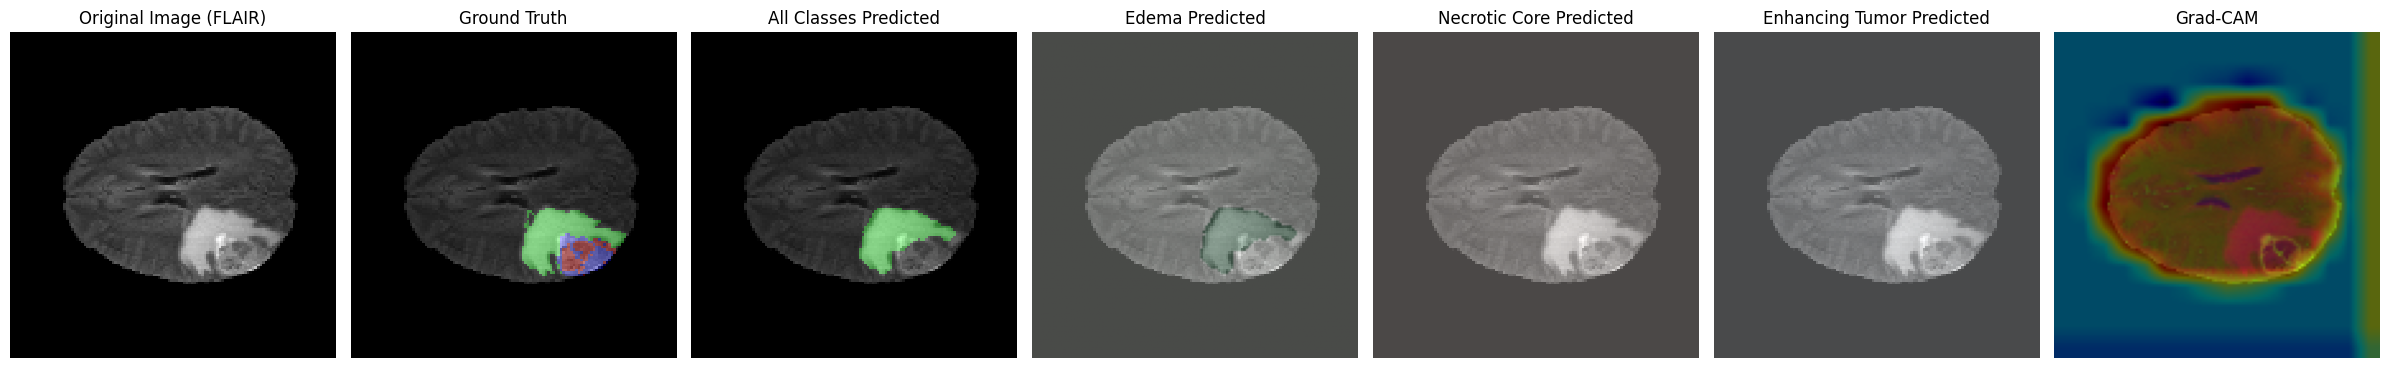

In [ ]:
visualize_predicted_class(case='004', start_slice=60)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


<Figure size 2400x1000 with 0 Axes>

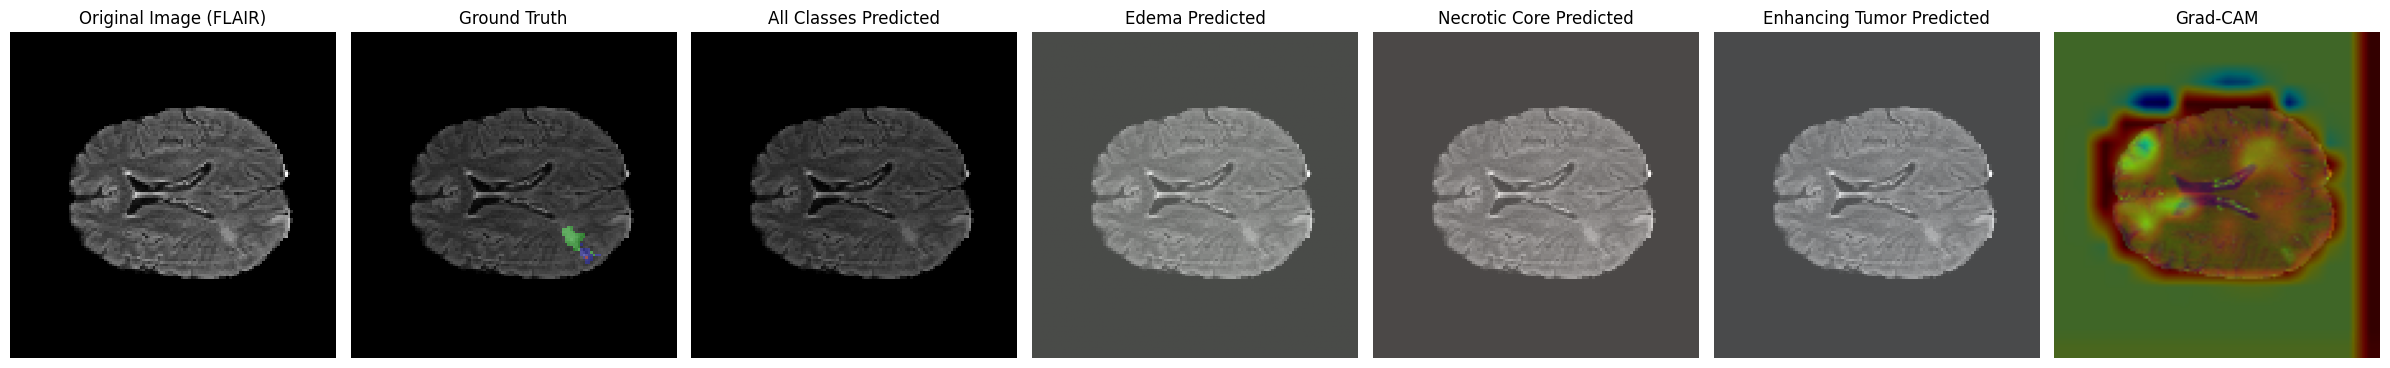

In [ ]:
visualize_predicted_class(case='005', start_slice=60)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


<Figure size 2400x1000 with 0 Axes>

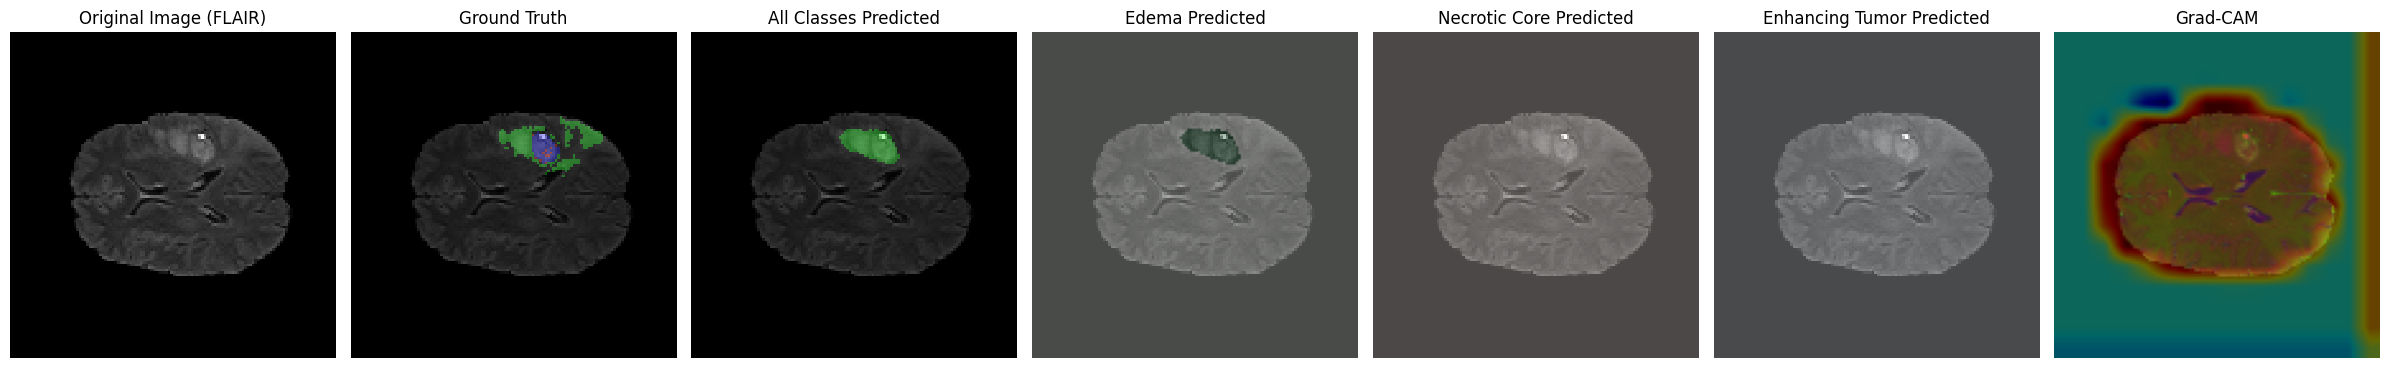

In [ ]:
visualize_predicted_class(case='010', start_slice=60)

In [ ]:
import random

In [ ]:

# def postprocess_mask(mask_pred, min_size=10):
#     from skimage import morphology
#     mask_pp = np.zeros_like(mask_pred)
#     classes = np.unique(mask_pred)
#     for c in classes:
#         if c == 0:
#             continue
#         mask_c = (mask_pred == c)
#         mask_c = morphology.remove_small_objects(mask_c, min_size=min_size)
#         mask_pp[mask_c] = c
#     return mask_pp

def predict_segmentation(sample_path):
    """
    Prédit la segmentation tumorale pour un volume IRM multimodal.
    Retourne le masque segmenté (post-traité) et les slices d'entrée (pour XAI).
    """
    # Charger les chemins des modalités
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    t2_path = sample_path + '_t2.nii'

    # Extraire les données des modalités
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()
    t2 = nib.load(t2_path).get_fdata()

    # Créer un tableau vide pour les données d'entrée
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 3))  # 3 modalités : FLAIR, T1CE, T2

    # Redimensionner et stocker les slices
    for j in range(VOLUME_SLICES):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 1] = cv2.resize(t1ce[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
        X[j, :, :, 2] = cv2.resize(t2[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

    # Normaliser les données (sécurisé)
    max_val = np.max(X)
    if max_val > 0:
        X = X / max_val

    # Prédiction brute du modèle
    y_pred = model.predict(X, verbose=1)  # (VOLUME_SLICES, IMG_SIZE, IMG_SIZE, n_classes)
    mask_pred = np.argmax(y_pred, axis=-1)  # (VOLUME_SLICES, IMG_SIZE, IMG_SIZE)

    # Post-traitement slice par slice
    mask_post = np.zeros_like(mask_pred)
    for i in range(mask_pred.shape[0]):
        mask_post[i] = postprocess_mask(mask_pred[i], min_size=100)

    # Retourne le masque segmenté et les slices d'entrée (pour XAI/Grad-CAM)
    return mask_post, X



In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap='viridis', norm=None):
    """
    Affiche les segmentations prédites et réelles pour un échantillon aléatoire.
    """
    # Choisir un patient aléatoire
    random_sample = random.choice(samples_list)
    random_sample_path = os.path.join(TRAIN_DATASET_PATH, random_sample, random_sample)

    # Prédire la segmentation du patient (retourne mask_post, X)
    predicted_seg, _ = predict_segmentation(random_sample_path)

    # Charger la segmentation originale (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Redimensionner la segmentation originale pour correspondre aux prédictions
    seg_resized = cv2.resize(
        seg[:, :, slice_to_plot + VOLUME_START_AT],
        (IMG_SIZE, IMG_SIZE),
        interpolation=cv2.INTER_NEAREST
    )

    # Extraire la slice prédite
    pred_slice = predicted_seg[slice_to_plot]  # (IMG_SIZE, IMG_SIZE)

    # Créer des masques binaires pour chaque classe
    background = (pred_slice == 0).astype(float)
    core = (pred_slice == 1).astype(float)
    edema = (pred_slice == 2).astype(float)
    enhancing = ((pred_slice == 3) | (pred_slice == 4)).astype(float)  # selon ton mapping

    # Pour affichage "toutes classes" (RGB)
    all_classes = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    all_classes[core == 1] = [1, 0, 0]      # Nécrose en rouge
    all_classes[edema == 1] = [0, 1, 0]     # Œdème en vert
    all_classes[enhancing == 1] = [0, 0, 1] # Zone améliorante en bleu

    print("Patient number:", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Segmentation originale
    axstest[0].imshow(seg_resized, cmap=cmap, norm=norm)
    axstest[0].set_title('Original Segmentation')

    # Toutes les classes prédites (affichage RGB)
    axstest[1].imshow(all_classes)
    axstest[1].set_title('Predicted Segmentation - All Classes')

    # Background
    axstest[2].imshow(background, cmap='gray')
    axstest[2].set_title('Predicted Segmentation - Background')

    # Nécrose/Core
    axstest[3].imshow(core, cmap='Reds')
    axstest[3].set_title('Predicted Segmentation - Necrotic/Core')

    # Œdème
    axstest[4].imshow(edema, cmap='Greens')
    axstest[4].set_title('Predicted Segmentation - Edema')

    # Zone améliorante
    axstest[5].imshow(enhancing, cmap='Blues')
    axstest[5].set_title('Predicted Segmentation - Enhancing')

    plt.subplots_adjust(wspace=0.8)
    plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Patient number: BraTS20_Training_290


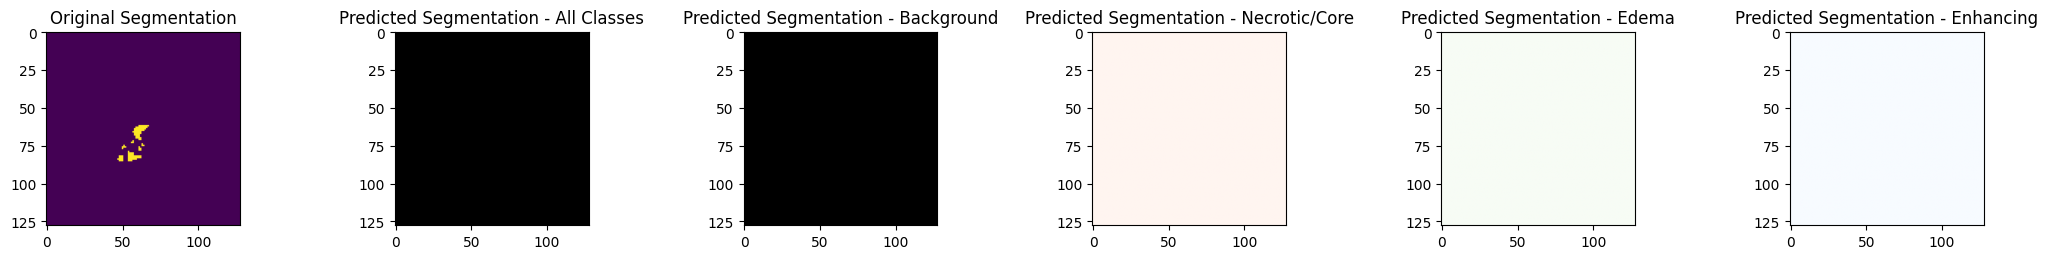

In [ ]:
show_predicted_segmentations(samples_list=train_patients, slice_to_plot=30)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Patient number: BraTS20_Training_105


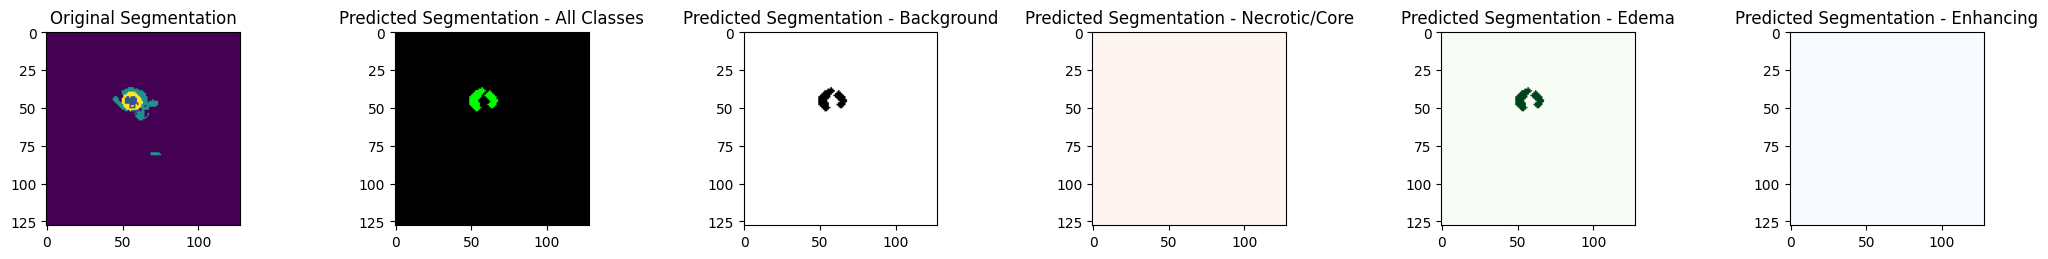

In [ ]:
show_predicted_segmentations(samples_list=train_patients, slice_to_plot=30)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Patient number: BraTS20_Training_145


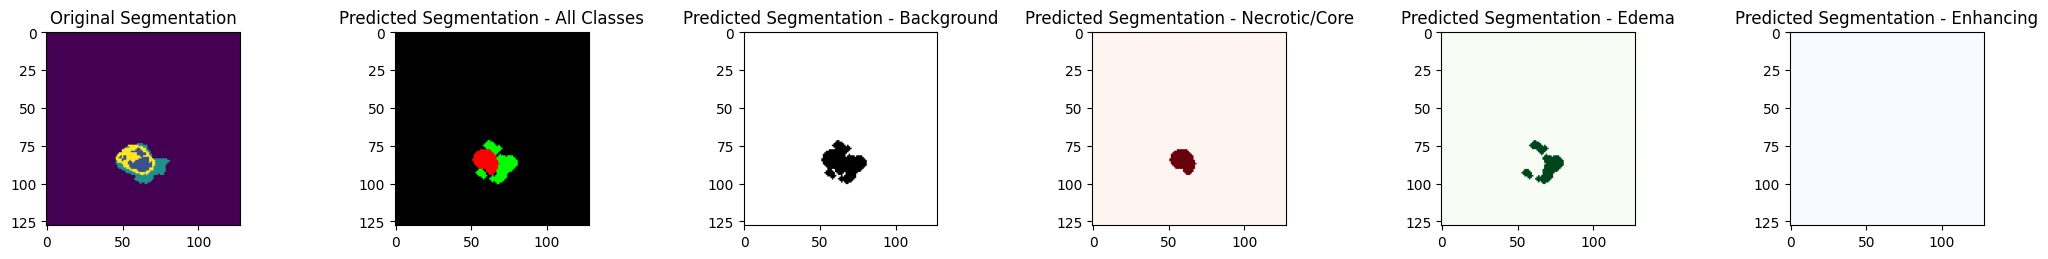

In [ ]:
show_predicted_segmentations(samples_list=train_patients, slice_to_plot=30)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step


<Figure size 1000x500 with 0 Axes>

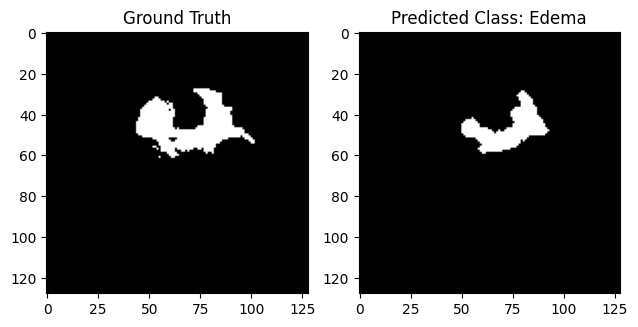

In [ ]:

# Définir les noms des classes
SEGMENT_CLASSES = {
    0: 'Background',
    1: 'Necrotic/Core',
    2: 'Edema',
    3: 'Enhancing'
}

# Sélectionner un cas spécifique
case = test_patients[2][-3:]  # Extraire l'identifiant du patient (exemple '003')
path = f"/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"

# Charger la segmentation réelle (Ground Truth)
gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()

# Effectuer la prédiction pour ce cas
mask_post, X = prediction_func(path, case)  # Dépaqueter le tuple

# Choisir la tranche à afficher
i = 40  # index de la slice

# Préparer le Ground Truth pour la classe spécifiée
eval_class = 2  # classe à évaluer (0=background, 1=nécrose, 2=œdème, 3=zone améliorante)
gt_copy = gt.copy()
gt_copy[gt_copy != eval_class] = 0
gt_copy[gt_copy == eval_class] = 1

# Redimensionner le Ground Truth pour correspondre à la taille du masque prédit
resized_gt = cv2.resize(
    gt_copy[:, :, i + VOLUME_START_AT],
    (IMG_SIZE, IMG_SIZE),
    interpolation=cv2.INTER_NEAREST
)

# Extraire la slice prédite et créer un masque binaire pour la classe évaluée
pred_slice = mask_post[i]  # masque 2D (IMG_SIZE, IMG_SIZE)
pred_class_mask = (pred_slice == eval_class).astype(float)

# Afficher les résultats
plt.figure(figsize=(10, 5))
f, axarr = plt.subplots(1, 2)

# Ground Truth
axarr[0].imshow(resized_gt, cmap="gray")
axarr[0].set_title('Ground Truth')

# Prédiction pour la classe spécifiée
axarr[1].imshow(pred_class_mask, cmap="gray")
axarr[1].set_title(f'Predicted Class: {SEGMENT_CLASSES[eval_class]}')

plt.tight_layout()
plt.show()


# 13. Évaluation

Appelons la fonction `evaluate()` pour évaluer les performances de notre modèle sur notre jeu de données de test :

In [ ]:
import pandas as pd

# Nettoyer toute variable potentiellement polluée
try:
    del metrics
except:
    pass


# Évaluer le modèle sur les données de test
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        'accuracy',
        tf.keras.metrics.MeanIoU(num_classes=4),
        dice_coef,
        precision,
        sensitivity,
        specificity,
        dice_coef_necrotic,
        dice_coef_edema,
        dice_coef_enhancing
    ]
)

# Évaluer le modèle
results = model.evaluate(test_generator, batch_size=100, callbacks=callbacks, verbose=0)

# Noms des métriques
descriptions = [
    "Loss", "Accuracy", "MeanIOU", "Dice coefficient", "Precision",
    "Sensitivity", "Specificity", "Dice coef Necrotic", "Dice coef Edema", "Dice coef Enhancing"
]

# Créer un DataFrame pour organiser les résultats
results_df = pd.DataFrame({
    "Metric": descriptions,
    "Value": [round(metric, 4) for metric in results]
})

# Afficher le DataFrame
print("\nModel evaluation on the test set:")
print("==================================")
print(results_df)

# Sauvegarder les résultats dans un fichier CSV (optionnel)
results_df.to_csv("/content/transunetDir/model_evaluation_results.csv", index=False)


Model evaluation on the test set:
                Metric   Value
0                 Loss  0.0299
1             Accuracy  0.9894
2              MeanIOU  0.8004
3     Dice coefficient  0.3982
4            Precision  0.9929
5          Sensitivity  0.9868
6          Specificity  0.9977
7   Dice coef Necrotic  0.2830
8      Dice coef Edema  0.4237
9  Dice coef Enhancing  0.2419


In [ ]:
!mv /content/transunetDir /content/drive/MyDrive/transUnetDirLast